# The Functional API
- https://www.tensorflow.org/guide/keras/functional

In [2]:
import numpy as np 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The Keras functional API: more flexible than the tf.keras.Sequential API
- non-linear topology, shared layers, and even multiple inputs or outputs.
- a way to build graphs of layers (DAG)

In [16]:
inputs = keras.Input(shape=(784,)) # batch size는 빠짐 (sample 하나의 shape만 선언되면 됨)
# img_inputs = keras.Input(shape=(32, 32, 3)) # input의 shape 외에, dtype도 필요
print(inputs.shape)
print(inputs.dtype)

(None, 784)
<dtype: 'float32'>


In [17]:
dense = layers.Dense(64, activation='relu')
x = dense(inputs) # "passing" the inputs to the dense layer (x: output)

In [18]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

In [19]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model") # Sequential과는 다른 모델 구조 정의 
# input -> x -> x -> outputs

In [20]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


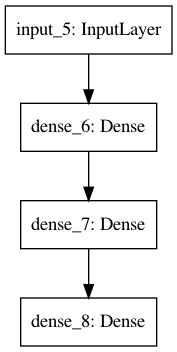

In [21]:
keras.utils.plot_model(model)

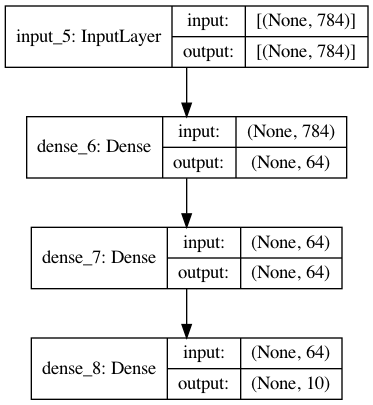

In [23]:
keras.utils.plot_model(model, show_shapes=True)
# the connection arrows are replaced by the call operation (layer call)

### Training, evaluation, and inference


In [26]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

In [27]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"]
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=2)

Epoch 1/2
750/750 [==============================] - 4s 4ms/step - loss: 0.5998 - accuracy: 0.8300 - val_loss: 0.1819 - val_accuracy: 0.9446
Epoch 2/2
750/750 [==============================] - 2s 2ms/step - loss: 0.1714 - accuracy: 0.9495 - val_loss: 0.1289 - val_accuracy: 0.9613
313/313 - 0s - loss: 0.1266 - accuracy: 0.9628


### Save and serialize 
- 표준 저장방식: model.save() - 모델 통째로 저장/로드
- 저장: 모델 아키텍쳐, 모델 가중치(학습 과정에서 얻어짐), 모델 학습 config(compile과정), 옵티마이저& 상태

In [28]:
model.save("path_to_my_model")
del model

INFO:tensorflow:Assets written to: path_to_my_model/assets


In [29]:
model = keras.models.load_model("path_to_my_model")

In [30]:
model

### Use the same graph of layers to define multiple models
- same stack of layers로 두 개 모델을 instantiate (encoder, autoencoder)

In [32]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

In [34]:
x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                

주의 
- the decoding architecture is strictly symmetrical to the encoding architecture
- so the output shape is the same as the input shape (28, 28, 1).

함수
- The reverse of a Conv2D layer = a Conv2DTranspose layer
- the reverse of a MaxPooling2D layer = an UpSampling2D layer.

### All models are callable, just like layers
- 모델도 레이어처럼 가져다 쓸 수 있음 

In [35]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

In [36]:
# model can be nested: a model can contain sub-models (like a layer)
autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input) # 모델 w/ input, output 
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder') # 새로운 모델
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                18672     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         9569      
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


In [38]:
# model nesting 대표 케이스: ensembling (single 모델 결과를 averaging)
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)

In [39]:
model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)

In [40]:
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

### Manipulate complex graph topologies
- 한 모델이 multiple input, output 가질 수 있음 (Sequential로는 처리 안 됨)

예시: 고객 이슈티켓 우선순위 정렬 & 각 부서에 라우팅
- 인풋 
    1. ticket title (text input)
    2. ticket 내용 (text input)
    3. ticket tags (categorical input)
- 아웃풋
    1. 우선순위 (0~1 점수 - scalar sigmoid)
    2. 티켓 담당 부서 (softmax output over 부서들..)
 

In [42]:
num_tags = 12
num_words = 10000 # 최대 words 수 (ticket title, text)
num_departments = 4

title_input = keras.Input(shape=(None,), name="title")
body_input = keras.Input(shape=(None,), name="body")
tags_input = keras.Input(shape=(num_tags,), name="tags")

In [43]:
title_features = layers.Embedding(num_words, 64)(title_input)
body_features = layers.Embedding(num_words, 64)(body_input)

title_features = layers.LSTM(128)(title_features)
body_features = layers.LSTM(32)(body_features)

In [45]:
x = layers.concatenate([title_features, body_features, tags_input])

In [46]:
# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)  # concatenated input x
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

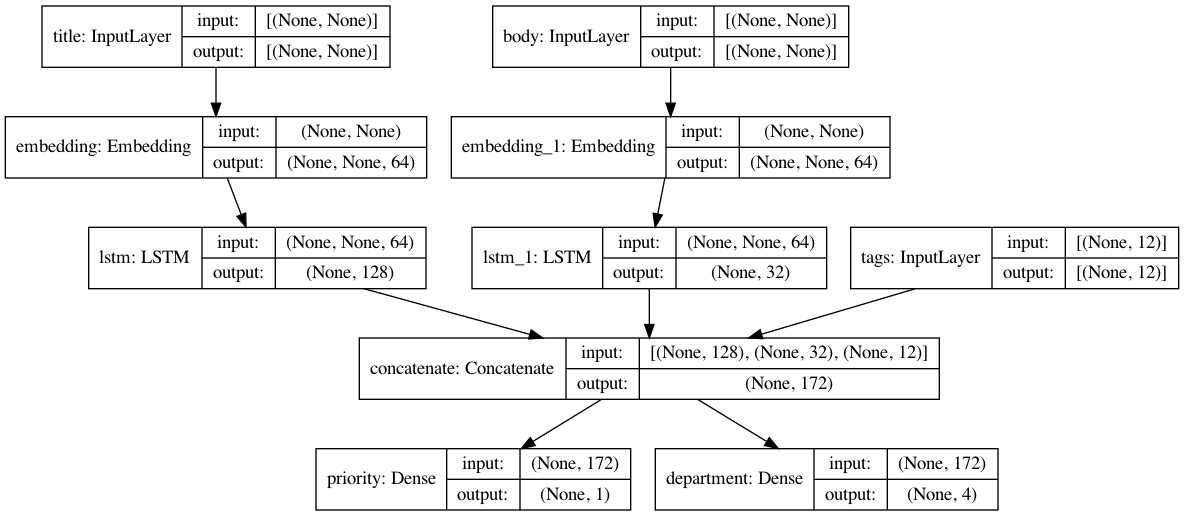

In [47]:
keras.utils.plot_model(model, show_shapes=True)

When compiling this model, 
- output마다 다른 losses 가능 
- 전체 학습 loss 계산 시, 각 output의 losses 간에 가중치 설정 가능

In [50]:
# model.compile(
#     optimizer=keras.optimizers.RMSprop(1e-3),
#     loss=[
#         keras.losses.BinaryCrossentropy(from_logits=True),
#         keras.losses.CategoricalCrossentropy(from_logits=True),
#     ],
#     loss_weights=[1.0, 0.2],
# )

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={ # 리스트로 줘도 되지만, 이름으로 안 헷갈리게
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2], # loss 간에 가중치
) 

In [51]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

In [52]:
# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

In [54]:
model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data}, # input kwargs
    {"priority": priority_targets, "department": dept_targets}, # output kwargs
#     리스트의 튜플도 가능: ([title_data, body_data, tags_data], [priority_targets, dept_targets])
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 1s 18ms/step - loss: 1.3057 - priority_loss: 0.7005 - department_loss: 3.0261
Epoch 2/2
40/40 [==============================] - 1s 17ms/step - loss: 1.2816 - priority_loss: 0.6987 - department_loss: 2.9146
